# Consistency Models Training Example

[![arXiv](https://img.shields.io/badge/arXiv-2301.01469-<COLOR>.svg)](https://arxiv.org/abs/2303.01469) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kinyugo/consistency_models/blob/main/notebooks/consistency_models_training_example.ipynb) [![GitHub Repo stars](https://img.shields.io/github/stars/Kinyugo/consistency_models?style=social) ](https://github.com/Kinyugo/consistency_models)

## 📖 Introduction

[Consistency Models](https://arxiv.org/abs/2303.01469) are a new family of generative models that achieve high sample quality without adversarial training. They support fast one-step generation by design, while still allowing for few-step sampling to trade compute for sample quality. They also support zero-shot data editing, like image inpainting, colorization, and super-resolution, without requiring explicit training on these tasks.


### Key Idea

_Learn a model that maps any arbitrary point in the latent space to the initial data point, i.e: if points lie on the same probability flow trajectory they are mapped to the same initial data point._

### Contributions

- Single step sampling
- Zero-shot data editing: inpainting, outpainting e.t.c

### Definition

Given a diffusion trajectory $x_{\sigma \in \left[\sigma_{min}, \sigma_{max}\right]}$, we define a consistency function $f : \left(x_{\sigma}, \sigma\right) \rightarrow x_{\sigma_{min}}$.

We can then train a consistency model $f_{\theta}\left(., . \right)$ to approximate the consistency function. A property of the consistency function is that $f : \left(x_{\sigma_{min}}, \sigma_{min} \right) \rightarrow x_{\sigma_{min}}$. To achieve this we parameterize the consistency model using skip connections as in [[2]](#2)

$$
f_{\theta}\left(x_{\sigma}, \sigma \right) = c_{skip}\left(\sigma \right)x_{\sigma} + c_{out}\left(\sigma \right)F_{\theta}\left(x_{\sigma}, \sigma \right)
$$

where $c_{skip}\left(\sigma_{min} \right) = 1$ and $c_{out}\left(\sigma_{min} \right) = 0$ and $F_{\theta}\left(.,.\right)$ is the neural network.

### Algorithms

#### Training

To train the model we follow the following algorithm:

```python
for current_training_step in range(total_training_steps):
    data = data_distribution()

  num_timesteps = timestep_schedule(current_training_step, total_training_steps, initial_timesteps, final_timesteps)
  sigmas = karras_schedule(num_timesteps, sigma_min, sigma_max)
  timesteps = uniform_distribution(batch_size, start=0, end=num_timesteps-1)
  noise = standard_gaussian_noise()

  current_sigmas = sigmas[timesteps]
  next_sigmas = sigmas[timesteps + 1]

  current_noisy_data = data + current_sigmas * noise
  next_noisy_data = data + next_sigmas * noise

  student_model_prediction = (skip_scaling(next_sigmas, sigma_data, sigma_min) * next_noisy_data 
                            + output_scaling(next_sigmas, sigma_data, sigma_min) * student_model(next_noisy_data, next_sigmas))

  with no_grad():
      teacher_model_prediction = (skip_scaling(current_sigmas, sigma_data, sigma_min) * current_noisy_data 
                                + output_scaling(current_sigmas, sigma_data, sigma_min) * teacher_model(current_noisy_data, next_sigmas))

  loss = distance_metric(student_model_prediction, teacher_model_prediction)

  loss.backward()

  with no_grad():
    current_ema_decay_rate = ema_decay_schedule(current_training_step, initial_ema_decay_rate, initial_timesteps)
    teacher_model_params = current_ema_decay_rate * teacher_model_params + (1 - current_ema_decay_rate) * student_model_params

```

#### Sampling

Starting from an initial random noise $\hat{x}_{\sigma_{max}} \sim \mathcal{N}(0, \sigma_{max}^2I)$, the consistency model can be used to sample a point in a single step: $\hat{x}_{\sigma_{min}} = f_{\theta}(x_{\sigma_{max}}, \sigma_{max})$. For iterative refinement, the following algorithm can be used:

```python
# Generate an initial sample from the initial random noise
sample = (skip_scaling(sigma_max, sigma_data, sigma_min) * x_sigma_max
                + output_scaling(sigma_max, sigma_data, sigma_min) * model(x_sigma_max, sigma_max))
sample = clamp?(sample)

for sigma in sigmas:
    noise = standard_gaussian_noise()
    noisy_sample = sample + square_root(square(sigma) - square(sigma_min)) * noise
    sample = (skip_scaling(sigma, sigma_data, sigma_min) * noisy_sample
                + output_scaling(sigma, sigma_data, sigma_min) * model(noisy_sample, sigma))
    sample = clamp?(sample)
```

where `consistency_model` $= f_{\theta}\left(.,.\right)$,
`clamp?` is a function that optionally clips values to a given range.

### References

<a id="1">[1]</a> Song, Y., Dhariwal, P., Chen, M., &amp; Sutskever, I. (2023, May 31). Consistency models. arXiv.org. https://arxiv.org/abs/2303.01469 

<a id="2">[2]</a> Karras, T., Aittala, M., Aila, T., &amp; Laine, S. (2022, October 11). Elucidating the design space of diffusion-based Generative Models. arXiv.org. https://arxiv.org/abs/2206.00364 

## 🛠️ Setup


### GPU Check

In [ ]:
!nvidia-smi

Sat Jan 27 08:10:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:AB:00.0 Off |                  Off |
|  0%   40C    P8              21W / 450W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Packages Installation

> **NOTE:** Restart the runtime if using colab after installing the packages.

In [7]:
%pip install -q lightning gdown torchmetrics einops torchinfo lpips --no-cache --upgrade
%pip install -q -e git+https://github.com/Kinyugo/consistency_models.git#egg=consistency_models

SyntaxError: invalid syntax (2632715329.py, line 2)

### Imports

In [2]:
import json
import os
from dataclasses import asdict, dataclass
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
from einops import rearrange
from einops.layers.torch import Rearrange
from lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from consistency_models import (
    ConsistencySamplingAndEditing,
    ConsistencyTraining,
    ema_decay_rate_schedule,
)
from consistency_models.utils import update_ema_model_

## 🧠  Implementation

### Data

#### Downloading and Extraction

In [3]:
!gdown 1FnzQLDPs-IlTTEr14YyENKjTYqZfn8mS  && tar -xf butterflies256.tar.gz # Butterflies Dataset
# !gdown 1m1QrNnKJy7hEzUQusyD3th_La775QKUV && tar -xf abstract_art.tar.gz  # Abstract Art Dataset
# !gdown 1VJow74U3H7KG_HOiP1WWo6LoqoE3azJj && tar -xf anime_faces.tar.gz # Anime Faces

Downloading...
From: https://drive.google.com/uc?id=1FnzQLDPs-IlTTEr14YyENKjTYqZfn8mS
To: /home/jwgu/git/consistency_models/notebooks/butterflies256.tar.gz
100%|██████████████████████████████████████| 9.13M/9.13M [00:00<00:00, 10.3MB/s]


#### DataModule

In [3]:
@dataclass
class ImageDataModuleConfig:
    data_dir: str = "butterflies256"
    image_size: Tuple[int, int] = (32, 32)
    batch_size: int = 32
    num_workers: int = 8
    pin_memory: bool = True
    persistent_workers: bool = True


class ImageDataModule(LightningDataModule):
    def __init__(self, config: ImageDataModuleConfig) -> None:
        super().__init__()

        self.config = config

    def setup(self, stage: str = None) -> None:
        transform = T.Compose(
            [
                T.Resize(self.config.image_size),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Lambda(lambda x: (x * 2) - 1),
            ]
        )
        self.dataset = ImageFolder(self.config.data_dir, transform=transform)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=self.config.pin_memory,
            persistent_workers=self.config.persistent_workers,
        )

### Modules

In [4]:
def GroupNorm(channels: int) -> nn.GroupNorm:
    return nn.GroupNorm(num_groups=min(32, channels // 4), num_channels=channels)


class SelfAttention(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        n_heads: int = 8,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.dropout = dropout

        self.qkv_projection = nn.Sequential(
            GroupNorm(in_channels),
            nn.Conv2d(in_channels, 3 * in_channels, kernel_size=1, bias=False),
            Rearrange("b (i h d) x y -> i b h (x y) d", i=3, h=n_heads),
        )
        self.output_projection = nn.Sequential(
            Rearrange("b h l d -> b l (h d)"),
            nn.Linear(in_channels, out_channels, bias=False),
            Rearrange("b l d -> b d l"),
            GroupNorm(out_channels),
            nn.Dropout1d(dropout),
        )
        self.residual_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        q, k, v = self.qkv_projection(x).unbind(dim=0)
        q = q.contiguous()
        k = k.contiguous()
        v = v.contiguous()
        
        output = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout if self.training else 0.0, is_causal=False
        )
        output = self.output_projection(output)
        output = rearrange(output, "b c (x y) -> b c x y", x=x.shape[-2], y=x.shape[-1])

        return output + self.residual_projection(x)


class UNetBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        noise_level_channels: int,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.input_projection = nn.Sequential(
            GroupNorm(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.Dropout2d(dropout),
        )
        self.noise_level_projection = nn.Sequential(
            nn.SiLU(),
            nn.Conv2d(noise_level_channels, out_channels, kernel_size=1),
        )
        self.output_projection = nn.Sequential(
            GroupNorm(out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            nn.Dropout2d(dropout),
        )
        self.residual_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: Tensor, noise_level: Tensor) -> Tensor:
        h = self.input_projection(x)
        h = h + self.noise_level_projection(noise_level)

        return self.output_projection(h) + self.residual_projection(x)


class UNetBlockWithSelfAttention(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        noise_level_channels: int,
        n_heads: int = 8,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.unet_block = UNetBlock(
            in_channels, out_channels, noise_level_channels, dropout
        )
        self.self_attention = SelfAttention(
            out_channels, out_channels, n_heads, dropout
        )

    def forward(self, x: Tensor, noise_level: Tensor) -> Tensor:
        return self.self_attention(self.unet_block(x, noise_level))


class Downsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()

        self.projection = nn.Sequential(
            Rearrange("b c (h ph) (w pw) -> b (c ph pw) h w", ph=2, pw=2),
            nn.Conv2d(4 * channels, channels, kernel_size=1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.projection(x)


class Upsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()

        self.projection = nn.Sequential(
            nn.Upsample(scale_factor=2.0, mode="nearest"),
            nn.Conv2d(channels, channels, kernel_size=3, padding="same"),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.projection(x)


class NoiseLevelEmbedding(nn.Module):
    def __init__(self, channels: int, scale: float = 16.0) -> None:
        super().__init__()

        self.W = nn.Parameter(torch.randn(channels // 2) * scale, requires_grad=False)

        self.projection = nn.Sequential(
            nn.Linear(channels, 4 * channels),
            nn.SiLU(),
            nn.Linear(4 * channels, channels),
            Rearrange("b c -> b c () ()"),
        )

    def forward(self, x: Tensor) -> Tensor:
        h = x[:, None] * self.W[None, :] * 2 * torch.pi
        h = torch.cat([torch.sin(h), torch.cos(h)], dim=-1)

        return self.projection(h)

### UNet

Our UNet is inspired by Stable Diffusion and Imagen. It's not the same UNet as the paper.

In [5]:
@dataclass
class UNetConfig:
    channels: int = 3
    noise_level_channels: int = 256
    noise_level_scale: float = 16.0
    n_heads: int = 8
    top_blocks_channels: Tuple[int, ...] = (128, 128)
    top_blocks_n_blocks_per_resolution: Tuple[int, ...] = (2, 2)
    top_blocks_has_resampling: Tuple[bool, ...] = (True, True)
    top_blocks_dropout: Tuple[float, ...] = (0.0, 0.0)
    mid_blocks_channels: Tuple[int, ...] = (256, 512)
    mid_blocks_n_blocks_per_resolution: Tuple[int, ...] = (4, 4)
    mid_blocks_has_resampling: Tuple[bool, ...] = (True, False)
    mid_blocks_dropout: Tuple[float, ...] = (0.0, 0.0)


class UNet(nn.Module):
    def __init__(self, config: UNetConfig) -> None:
        super().__init__()

        self.config = config

        self.input_projection = nn.Conv2d(
            config.channels,
            config.top_blocks_channels[0],
            kernel_size=3,
            padding="same",
        )
        self.noise_level_embedding = NoiseLevelEmbedding(
            config.noise_level_channels, config.noise_level_scale
        )
        self.top_encoder_blocks = self._make_encoder_blocks(
            self.config.top_blocks_channels + self.config.mid_blocks_channels[:1],
            self.config.top_blocks_n_blocks_per_resolution,
            self.config.top_blocks_has_resampling,
            self.config.top_blocks_dropout,
            self._make_top_block,
        )
        self.mid_encoder_blocks = self._make_encoder_blocks(
            self.config.mid_blocks_channels + self.config.mid_blocks_channels[-1:],
            self.config.mid_blocks_n_blocks_per_resolution,
            self.config.mid_blocks_has_resampling,
            self.config.mid_blocks_dropout,
            self._make_mid_block,
        )
        self.mid_decoder_blocks = self._make_decoder_blocks(
            self.config.mid_blocks_channels + self.config.mid_blocks_channels[-1:],
            self.config.mid_blocks_n_blocks_per_resolution,
            self.config.mid_blocks_has_resampling,
            self.config.mid_blocks_dropout,
            self._make_mid_block,
        )
        self.top_decoder_blocks = self._make_decoder_blocks(
            self.config.top_blocks_channels + self.config.mid_blocks_channels[:1],
            self.config.top_blocks_n_blocks_per_resolution,
            self.config.top_blocks_has_resampling,
            self.config.top_blocks_dropout,
            self._make_top_block,
        )
        self.output_projection = nn.Conv2d(
            config.top_blocks_channels[0],
            config.channels,
            kernel_size=3,
            padding="same",
        )

    def forward(self, x: Tensor, noise_level: Tensor) -> Tensor:
        h = self.input_projection(x)
        noise_level = self.noise_level_embedding(noise_level)

        top_encoder_embeddings = []
        for block in self.top_encoder_blocks:
            if isinstance(block, UNetBlock):
                h = block(h, noise_level)
                top_encoder_embeddings.append(h)
            else:
                h = block(h)

        mid_encoder_embeddings = []
        for block in self.mid_encoder_blocks:
            if isinstance(block, UNetBlockWithSelfAttention):
                h = block(h, noise_level)
                mid_encoder_embeddings.append(h)
            else:
                h = block(h)

        for block in self.mid_decoder_blocks:
            if isinstance(block, UNetBlockWithSelfAttention):
                h = torch.cat((h, mid_encoder_embeddings.pop()), dim=1)
                h = block(h, noise_level)
            else:
                h = block(h)

        for block in self.top_decoder_blocks:
            if isinstance(block, UNetBlock):
                h = torch.cat((h, top_encoder_embeddings.pop()), dim=1)
                h = block(h, noise_level)
            else:
                h = block(h)

        return self.output_projection(h)

    def _make_encoder_blocks(
        self,
        channels: Tuple[int, ...],
        n_blocks_per_resolution: Tuple[int, ...],
        has_resampling: Tuple[bool, ...],
        dropout: Tuple[float, ...],
        block_fn: Callable[[], nn.Module],
    ) -> nn.ModuleList:
        blocks = nn.ModuleList()

        channel_pairs = list(zip(channels[:-1], channels[1:]))
        for idx, (in_channels, out_channels) in enumerate(channel_pairs):
            for _ in range(n_blocks_per_resolution[idx]):
                blocks.append(block_fn(in_channels, out_channels, dropout[idx]))
                in_channels = out_channels

            if has_resampling[idx]:
                blocks.append(Downsample(out_channels))

        return blocks

    def _make_decoder_blocks(
        self,
        channels: Tuple[int, ...],
        n_blocks_per_resolution: Tuple[int, ...],
        has_resampling: Tuple[bool, ...],
        dropout: Tuple[float, ...],
        block_fn: Callable[[], nn.Module],
    ) -> nn.ModuleList:
        blocks = nn.ModuleList()

        channel_pairs = list(zip(channels[:-1], channels[1:]))[::-1]
        for idx, (out_channels, in_channels) in enumerate(channel_pairs):
            if has_resampling[::-1][idx]:
                blocks.append(Upsample(in_channels))

            inner_blocks = []
            for _ in range(n_blocks_per_resolution[::-1][idx]):
                inner_blocks.append(
                    block_fn(in_channels * 2, out_channels, dropout[::-1][idx])
                )
                out_channels = in_channels
            blocks.extend(inner_blocks[::-1])

        return blocks

    def _make_top_block(
        self, in_channels: int, out_channels: int, dropout: float
    ) -> UNetBlock:
        return UNetBlock(
            in_channels,
            out_channels,
            self.config.noise_level_channels,
            dropout,
        )

    def _make_mid_block(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float,
    ) -> UNetBlockWithSelfAttention:
        return UNetBlockWithSelfAttention(
            in_channels,
            out_channels,
            self.config.noise_level_channels,
            self.config.n_heads,
            dropout,
        )

    def save_pretrained(self, pretrained_path: str) -> None:
        os.makedirs(pretrained_path, exist_ok=True)

        with open(os.path.join(pretrained_path, "config.json"), mode="w") as f:
            json.dump(asdict(self.config), f)

        torch.save(self.state_dict(), os.path.join(pretrained_path, "model.pt"))

    @classmethod
    def from_pretrained(cls, pretrained_path: str) -> "UNet":
        with open(os.path.join(pretrained_path, "config.json"), mode="r") as f:
            config_dict = json.load(f)
        config = UNetConfig(**config_dict)

        model = cls(config)

        state_dict = torch.load(
            os.path.join(pretrained_path, "model.pt"), map_location=torch.device("cpu")
        )
        model.load_state_dict(state_dict)

        return model


summary(UNet(UNetConfig()), input_size=((1, 3, 32, 32), (1,)))

### LitUNet

In [6]:
@dataclass
class LitConsistencyModelConfig:
    initial_ema_decay_rate: float = 0.95
    student_model_ema_decay_rate: float = 0.99993
    lr: float = 1e-4
    betas: Tuple[float, float] = (0.9, 0.995)
    lr_scheduler_start_factor: float = 1e-5
    lr_scheduler_iters: int = 10_000
    sample_every_n_steps: int = 10_000
    num_samples: int = 8
    sampling_sigmas: Tuple[Tuple[int, ...], ...] = (
        (80,),
        (80.0, 0.661),
        (80.0, 24.4, 5.84, 0.9, 0.661),
    )


class LitConsistencyModel(LightningModule):
    def __init__(
        self,
        consistency_training: ConsistencyTraining,
        consistency_sampling: ConsistencySamplingAndEditing,
        student_model: UNet,
        teacher_model: UNet,
        ema_student_model: UNet,
        config: LitConsistencyModelConfig,
    ) -> None:
        super().__init__()

        self.consistency_training = consistency_training
        self.consistency_sampling = consistency_sampling
        self.student_model = student_model
        self.teacher_model = teacher_model
        self.ema_student_model = ema_student_model
        self.config = config
        self.num_timesteps = self.consistency_training.initial_timesteps

        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type="alex")

        # Freeze teacher and EMA student models and set to eval mode
        for param in self.teacher_model.parameters():
            param.requires_grad = False
        for param in self.ema_student_model.parameters():
            param.requires_grad = False
        self.teacher_model = self.teacher_model.eval()
        self.ema_student_model = self.ema_student_model.eval()

    def training_step(self, batch: Union[Tensor, List[Tensor]], batch_idx: int) -> None:
        if isinstance(batch, list):
            batch = batch[0]

        output = self.consistency_training(
            self.student_model,
            self.teacher_model,
            batch,
            self.global_step,
            self.trainer.max_steps,
        )
        self.num_timesteps = output.num_timesteps

        lpips_loss = self.lpips(
            output.predicted.clamp(-1.0, 1.0), output.target.clamp(-1.0, 1.0)
        )
        overflow_loss = F.mse_loss(
            output.predicted, output.predicted.detach().clamp(-1.0, 1.0)
        )
        loss = lpips_loss + overflow_loss

        self.log_dict(
            {
                "train_loss": loss,
                "lpips_loss": lpips_loss,
                "overflow_loss": overflow_loss,
                "num_timesteps": output.num_timesteps,
            }
        )

        return loss

    def on_train_batch_end(
        self, outputs: Any, batch: Union[Tensor, List[Tensor]], batch_idx: int
    ) -> None:
        # Update teacher model
        ema_decay_rate = ema_decay_rate_schedule(
            self.num_timesteps,
            self.config.initial_ema_decay_rate,
            self.consistency_training.initial_timesteps,
        )
        update_ema_model_(self.teacher_model, self.student_model, ema_decay_rate)
        self.log_dict({"ema_decay_rate": ema_decay_rate})

        # Update EMA student model
        update_ema_model_(
            self.ema_student_model,
            self.student_model,
            self.config.student_model_ema_decay_rate,
        )

        if (
            (self.global_step + 1) % self.config.sample_every_n_steps == 0
        ) or self.global_step == 0:
            self.__sample_and_log_samples(batch)

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.student_model.parameters(), lr=self.config.lr, betas=self.config.betas
        )
        sched = torch.optim.lr_scheduler.LinearLR(
            opt,
            start_factor=self.config.lr_scheduler_start_factor,
            total_iters=self.config.lr_scheduler_iters,
        )
        sched = {"scheduler": sched, "interval": "step", "frequency": 1}

        return [opt], [sched]

    @torch.no_grad()
    def __sample_and_log_samples(self, batch: Union[Tensor, List[Tensor]]) -> None:
        if isinstance(batch, list):
            batch = batch[0]

        # Ensure the number of samples does not exceed the batch size
        num_samples = min(self.config.num_samples, batch.shape[0])
        noise = torch.randn_like(batch[:num_samples])

        # Log ground truth samples
        self.__log_images(
            batch[:num_samples].detach().clone(), f"ground_truth", self.global_step
        )

        for sigmas in self.config.sampling_sigmas:
            samples = self.consistency_sampling(
                self.ema_student_model, noise, sigmas, clip_denoised=True, verbose=True
            )
            samples = samples.clamp(min=-1.0, max=1.0)

            # Generated samples
            self.__log_images(
                samples,
                f"generated_samples-sigmas={sigmas}",
                self.global_step,
            )

    @torch.no_grad()
    def __log_images(self, images: Tensor, title: str, global_step: int) -> None:
        images = images.detach().float()

        grid = make_grid(
            images.clamp(-1.0, 1.0), value_range=(-1.0, 1.0), normalize=True
        )
        self.logger.experiment.add_image(title, grid, global_step)

## 🚀 Training

### Training Loop

In [7]:
@dataclass
class TrainingConfig:
    image_dm_config: ImageDataModuleConfig
    unet_config: UNetConfig
    consistency_training: ConsistencyTraining
    consistency_sampling: ConsistencySamplingAndEditing
    lit_cm_config: LitConsistencyModelConfig
    trainer: Trainer
    seed: int = 42
    model_ckpt_path: str = "checkpoints/cm"
    resume_ckpt_path: Optional[str] = None


def run_training(config: TrainingConfig) -> None:
    # Set seed
    seed_everything(config.seed)

    # Create data module
    dm = ImageDataModule(config.image_dm_config)

    # Create student and teacher models and EMA student model
    student_model = UNet(config.unet_config)
    teacher_model = UNet(config.unet_config)
    teacher_model.load_state_dict(student_model.state_dict())
    ema_student_model = UNet(config.unet_config)
    ema_student_model.load_state_dict(student_model.state_dict())

    # Create lightning module
    lit_cm = LitConsistencyModel(
        config.consistency_training,
        config.consistency_sampling,
        student_model,
        teacher_model,
        ema_student_model,
        config.lit_cm_config,
    )

    # Run training
    config.trainer.fit(lit_cm, dm, ckpt_path=config.resume_ckpt_path)

    # Save model
    lit_cm.ema_student_model.save_pretrained(config.model_ckpt_path)

### Run Training

> **NOTE:** While the paper suggests a final_timesteps value of `150`, it's important to note that during my experimentation on a smaller dataset with approximately 10,000 training steps, I discovered that setting final_timesteps to `17` yielded superior results. This value corresponds to the number of timesteps that would be obtained if we were to train for the same number of steps as mentioned in the paper (600,000 to 1,000,000). However, it's crucial to emphasize that this particular setting has not been extensively explored or experimented with, so it may require further fine-tuning and adjustment to suit your specific needs.

In [9]:
training_config = TrainingConfig(
    image_dm_config=ImageDataModuleConfig("butterflies256"),
    unet_config=UNetConfig(),
    consistency_training=ConsistencyTraining(final_timesteps=17),
    consistency_sampling=ConsistencySamplingAndEditing(),
    lit_cm_config=LitConsistencyModelConfig(
        sample_every_n_steps=1000, lr_scheduler_iters=1000
    ),
    trainer=Trainer(
        max_steps=10_000,
        precision="16-mixed",
        log_every_n_steps=10,
        logger=TensorBoardLogger(".", name="logs", version="cm"),
        callbacks=[LearningRateMonitor(logging_interval="step")],
    ),
)
run_training(training_config)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type                                  | Params
-----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

/home/jwgu/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


RuntimeError: query: last dimension must be contiguous

## 🎲 Sampling & Zero-shot Editing

In [10]:
seed_everything(42)

Seed set to 42


42

### Utils

In [11]:
def plot_images(images: Tensor, cols: int = 4) -> None:
    rows = max(images.shape[0] // cols, 1)
    fig, axs = plt.subplots(rows, cols)
    axs = axs.flatten()
    for i, image in enumerate(images):
        axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
        axs[i].set_axis_off()

### Checkpoint Loading

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

unet = UNet.from_pretrained("checkpoints/cm").eval().to(device=device, dtype=dtype)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/cm/config.json'

### Load Sample Batch

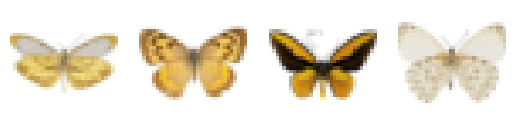

In [13]:
dm = ImageDataModule(ImageDataModuleConfig("butterflies256", batch_size=4))
dm.setup()

batch, _ = next(iter(dm.train_dataloader()))
batch = batch.to(device=device, dtype=dtype)

plot_images(batch.float().cpu())

### Experiments

#### Sampling

In [14]:
consistency_sampling_and_editing = ConsistencySamplingAndEditing()

with torch.no_grad():
    samples = consistency_sampling_and_editing(
        unet,
        torch.randn((4, 3, 32, 32), device=device, dtype=dtype),
        sigmas=[80.0],  # Use more steps for better samples e.g 2-5
        clip_denoised=True,
        verbose=True,
    )

plot_images(samples.float().cpu())

NameError: name 'unet' is not defined

#### Inpainting

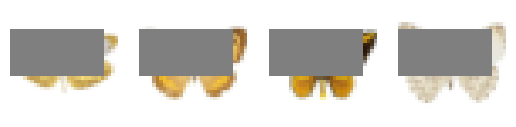

In [15]:
random_erasing = T.RandomErasing(p=1.0, scale=(0.2, 0.5), ratio=(0.5, 0.5))
masked_batch = random_erasing(batch)
mask = torch.logical_not(batch == masked_batch)

plot_images(masked_batch.float().cpu())

In [ ]:
with torch.no_grad():
    inpainted_batch = consistency_sampling_and_editing(
        unet,
        masked_batch,
        sigmas=[5.23, 2.25],
        mask=mask.to(dtype=dtype),
        clip_denoised=True,
        verbose=True,
    )

plot_images(torch.cat((masked_batch, inpainted_batch), dim=0).float().cpu())

#### Interpolation

In [ ]:
batch_a = batch.clone()
batch_b = torch.flip(batch, dims=(0,))

plot_images(torch.cat((batch_a, batch_b), dim=0).float().cpu())

In [ ]:
with torch.no_grad():
    interpolated_batch = consistency_sampling_and_editing.interpolate(
        unet,
        batch_a,
        batch_b,
        ab_ratio=0.5,
        sigmas=[5.23, 2.25],
        clip_denoised=True,
        verbose=True,
    )

plot_images(torch.cat((batch_a, batch_b, interpolated_batch), dim=0).float().cpu())